In [1]:
from sentence_to_predicate import WordPredicate
import json
import sentence_grounding_test_parameters as param
import numpy as np
from recognized_object import RecognizedObject

from plots import *
from data_processing import *

import sys
import time
import matplotlib.pyplot as plt
import math
import os
from sklearn.model_selection import KFold
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from tensorflow import keras

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Masking, GRU
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from transformers import BertModel, BertTokenizer
from transformers import pipeline
from attention import Attention

/home/subbainria/anaconda3/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [3]:
def padding(data_set, max_seq_len = None, special_value = -42):
    if data_set is None:
        return  np.full((1, max_seq_len, nb_unique_words), fill_value=special_value)

    if max_seq_len is None:
        max_seq_len = max([len(s) for s in data_set])

    data_set_pad = np.full((len(data_set), max_seq_len, nb_unique_words), fill_value=special_value)

    for s, x in enumerate(data_set):
        if x is None:
            continue
        seq_len = x.shape[0]
        data_set_pad[s, 0:seq_len, :] = x
    return data_set_pad

In [4]:
def test_with_sentences(sentences, model):
    global max_seq_len
    test = [one_hot_encoding_sentence(s) for s in sentences]
    test_pad = padding(test, max_seq_len)
    res = model.predict(test_pad)
    return res

In [5]:
def test_on_test_set(model, testX, testY, sentences, verbose, threshold_factor):
    test_outputs = model.predict(testX)
    test_res = model.test_on_batch(testX, testY)
    exact = 0
    valid = 0
    for i in range(len(test_outputs)):
        v = output_to_vision(test_outputs[i],nb_concepts,
                             threshold_factor, concepts_delimitations, output_id_to_concept_dict)
        pred = sentence_to_pred(sentences[i], sent_to_role)

        if is_an_exact_representation(pred, v):
            exact +=1

        if is_a_valid_representation(pred, v):
            valid +=1

        if is_a_valid_representation(pred, v) and not(is_an_exact_representation(pred, v)):
            #print(pred, v, test_outputs[i])
            #print(i)
            pass

    nb_sample = testX.shape[0]
    if verbose:
        print("Valid representations : ", valid, "/", nb_sample)
        print("Exact representations : ", exact, "/", nb_sample)
        print("MSE on test : ", test_res)
        print("RMSE on test : ", np.sqrt(test_res))


    return 1-valid/nb_sample, 1-exact/nb_sample, test_res

In [6]:
## to get the evolution of the loss during training
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.exact_errors = []
        self.valid_errors = []

    def on_epoch_end(self, epoch, logs=None):
        global validationX_pad
        global validationY
        self.losses.append(logs.get('loss'))

        v, ex, er = test_on_test_set(self.model, validationX_pad, validationY, validation_sentences, True, 1.3)

        self.val_losses.append(er)
        self.exact_errors.append(ex)
        self.valid_errors.append(v)

    def plot_loss(self):
        plt.figure()
        plt.plot(self.losses, color = "black", label = "loss")
        plt.plot(self.val_losses, color = "red", label = "loss on validation set")
        plt.xlabel("epochs of training")
        plt.title("MSE during training")
        plt.legend()
        plt.show()
        plt.figure()
        plt.title("Performance on validation set during training")
        plt.plot(self.exact_errors, color = "blue", label = "exact error")
        plt.plot(self.valid_errors, color = "green", label = "valid error")
        plt.legend()
        plt.show()

In [7]:
def get_successive_outputs(sentence, model):
    words = sentence.split(" ")
    prefixes = []
    for i in range(len(words)+1):
        prefixes.append(" ".join(words[:i]))
    vect = test_with_sentences(prefixes, model)
    return vect

In [8]:
def get_inner_states(sentences, model, only_last = False, info_obj_nb = False):
    all_states = [[] for i in range(len(model.outputs))]

    clause_nbs =[]

    for k in range(len(sentences)):
        states = get_successive_outputs(sentences[k], model)

        if info_obj_nb:
            words = sentences[k].split(" ")
            clause_id = 0
            clause_nbs.append(clause_id)
            for w in words:
                if w == 'and':
                    clause_id +=1
                clause_nbs.append(clause_id)
                if w == 'and':
                    clause_id +=1
            clause_nbs[-1] = 3 #we also mark the final states

        if not(only_last):
            for j in range(len(states)):
                all_states[j].append(states[j])
        else:
            for j in range(len(states)):
                all_states[j].append(states[j][-1] )

    if not(only_last):
        for i in range(len(all_states)):
            all_states[i] = np.concatenate(all_states[i])
    else:
        for i in range(len(all_states)):
            all_states[i] = np.array(all_states[i])

    if info_obj_nb:
        return all_states, np.array(clause_nbs)
    else:
        return all_states

In [9]:
def plot_hidden_states(sentence, model_for_test, state = 'cell', units_to_plot = 'all', plt_var = False, plt_sum = False):
    activations = get_successive_outputs(sentence, model_for_test)

    plot_hidden_state_activation(sentence,
                                 activations,
                                 state,
                                 units_to_plot,
                                 plot_variation = plt_var,
                                 plot_sum = plt_sum)

In [10]:
################### MAIN #####################

## Parameters

add_begin_end = True #add the word "BEGIN" at the beggining and "END" at the end of all sentences ?
nb_objects = 4 #number of object in the vocabulary used to generate the sentences (the bigger the harder)


special_value = -42 #special value for masking
batch_size = 2
nb_epoch = 70
lstm_units = 20
dropout = 0.2
test_version = True #if we just create a model to do the task (named "model" in the code)
                    #or in addition, create a model to do extensive test to get access to
                    #cell states of the LSTM (named "model_for_test" in the code)

use_save_version = False #use model saved from a previous run
if use_save_version:
    path = r"saved_LSTM/" #path to the model .hdf5 file(s)
    model_id = '0.9144544314163248' #model id (a random float to identify the file(s) of the model save)

threshold_factor = 1.3 # the factor used to get the threshold in the creation of he discrete representation


minimal_mode = False #if minimal mode is on, the model will only be trained and tested on test set. The only text print will be "nb of objects, valid error on test set, exact error on test set, RMSE on test set, time to train"

verbose_training = True

In [11]:
##dataset initialisation : creation of the sentence according to the grammar

param.create_dataset(nb_objects = nb_objects)

#one hot encoding initialisation
sent_to_role= param.SENTENCE_TO_ROLES


other_words = ['and']
if add_begin_end:
    other_words.append("BEGIN")
    other_words.append("END")

init_one_hot_encoding(list(sent_to_role.keys()) + other_words)
nb_unique_words = len(word2one_hot_id)


In [12]:
#concept dictionnary initialisation (it's the link between the output position and their meaning)
concepts = param.CATEGORIES + param.POSITIONS + param.COLORS

concepts_delimitations = [(0,len(param.CATEGORIES)),
                          (len(param.CATEGORIES),
                          len(param.CATEGORIES) + len(param.POSITIONS)),
                          (len(param.CATEGORIES) + len(param.POSITIONS),
                          len(param.CATEGORIES) + len(param.POSITIONS)+ len(param.COLORS))]

nb_concepts = len(concepts)

output_size = 2*nb_concepts

concept_to_output_id_dict = {}
output_id_to_concept_dict = {}
for i,c in enumerate(concepts):
    concept_to_output_id_dict[c] = i
    output_id_to_concept_dict[i] = c

In [13]:
##generate data

sentences_one_object = list(sent_to_role.keys())
sentences_two_objects = []

for s1 in sentences_one_object:
    for s2 in sentences_one_object:
        sentences_two_objects.append(s1 + " and " + s2)

#we adjust the different dictionnaries to include sentences with BEGIN and END

if add_begin_end:
    for i in range(len(sentences_one_object)):

        sent_to_role["BEGIN "+ sentences_one_object[i]+ " END"] = [0] + sent_to_role[sentences_one_object[i]] + [0]
        sent_to_role["BEGIN "+ sentences_one_object[i]] = [0] + sent_to_role[sentences_one_object[i]]
        sent_to_role[ sentences_one_object[i] + " END"] = sent_to_role[sentences_one_object[i]] + [0]
        sentences_one_object[i] = "BEGIN "+ sentences_one_object[i]+ " END"

    for i in range(len(sentences_two_objects)):
        sentences_two_objects[i] = "BEGIN "+ sentences_two_objects[i]+ " END"

In [14]:
#create the training, test and validation set

np.random.shuffle(sentences_one_object)
np.random.shuffle(sentences_two_objects)

train_one_obj = 300
train_two_objs = 700


test_one_obj = 300
test_two_objs = 700

validation_one_obj = 80
validation_two_objs = 200


In [15]:
train_sentences = (sentences_one_object[:train_one_obj]
              + sentences_two_objects[:train_two_objs])


test_sentences = (sentences_one_object[-test_one_obj:]
              + sentences_two_objects[-test_two_objs:])

validation_sentences = (sentences_one_object[train_one_obj:train_one_obj+validation_one_obj]
              + sentences_two_objects[train_two_objs:train_two_objs+validation_two_objs])


In [16]:
trainX = [one_hot_encoding_sentence(s) for s in train_sentences]
trainY = np.array([sentence_to_output_teacher_vector(s, sent_to_role, concept_to_output_id_dict, nb_concepts) for s in train_sentences])

In [17]:
testX = [one_hot_encoding_sentence(s) for s in test_sentences]
testY = np.array([sentence_to_output_teacher_vector(s, sent_to_role, concept_to_output_id_dict, nb_concepts) for s in test_sentences])

In [18]:
validationX = [one_hot_encoding_sentence(s) for s in validation_sentences]
validationY = np.array([sentence_to_output_teacher_vector(s, sent_to_role, concept_to_output_id_dict, nb_concepts) for s in validation_sentences])

In [19]:
max_seq_len = max([len(s.split(" ")) for s in sentences_two_objects])

trainX_pad = padding(trainX,max_seq_len = max_seq_len)
testX_pad = padding(testX, max_seq_len = max_seq_len)
validationX_pad = padding(validationX, max_seq_len = max_seq_len)

In [20]:
print(trainX_pad.shape, testX_pad.shape, validationX_pad.shape)

(1000, 19, 20) (1000, 19, 20) (280, 19, 20)


Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
masking_10 (Masking)            (None, 19, 20)       0           input_11[0][0]                   
__________________________________________________________________________________________________
lstm_10 (LSTM)                  [(None, 19, 20), (No 3280        masking_10[0][0]                 
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 20)           0           lstm_10[0][0]                    
___________________________________________________________________________________________

Epoch 8/70
Valid representations :  115 / 280
Exact representations :  77 / 280
MSE on test :  0.0833514928817749
RMSE on test :  0.28870658614201183

Epoch 00008: val_loss improved from 0.08891 to 0.08335, saving model to saved_LSTM/best_model0.36185208387908063.hdf5
500/500 - 3s - loss: 0.0970 - val_loss: 0.0834
Epoch 9/70
Valid representations :  149 / 280
Exact representations :  115 / 280
MSE on test :  0.07538831979036331
RMSE on test :  0.27456933512386866

Epoch 00009: val_loss improved from 0.08335 to 0.07539, saving model to saved_LSTM/best_model0.36185208387908063.hdf5
500/500 - 3s - loss: 0.0948 - val_loss: 0.0754
Epoch 10/70
Valid representations :  163 / 280
Exact representations :  121 / 280
MSE on test :  0.07285802066326141
RMSE on test :  0.26992224929275727

Epoch 00010: val_loss improved from 0.07539 to 0.07286, saving model to saved_LSTM/best_model0.36185208387908063.hdf5
500/500 - 3s - loss: 0.0905 - val_loss: 0.0729
Epoch 11/70
Valid representations :  202 / 280


Epoch 35/70
Valid representations :  277 / 280
Exact representations :  273 / 280
MSE on test :  0.048196930438280106
RMSE on test :  0.21953799315444264

Epoch 00035: val_loss did not improve from 0.04806
500/500 - 3s - loss: 0.0722 - val_loss: 0.0482
Epoch 36/70
Valid representations :  280 / 280
Exact representations :  272 / 280
MSE on test :  0.04757024347782135
RMSE on test :  0.21810603723377617

Epoch 00036: val_loss improved from 0.04806 to 0.04757, saving model to saved_LSTM/best_model0.36185208387908063.hdf5
500/500 - 3s - loss: 0.0716 - val_loss: 0.0476
Epoch 37/70
Valid representations :  272 / 280
Exact representations :  269 / 280
MSE on test :  0.04786483943462372
RMSE on test :  0.21878034517438655

Epoch 00037: val_loss did not improve from 0.04757
500/500 - 3s - loss: 0.0712 - val_loss: 0.0479
Epoch 38/70
Valid representations :  276 / 280
Exact representations :  272 / 280
MSE on test :  0.04734236001968384
RMSE on test :  0.21758299570436068

Epoch 00038: val_loss 

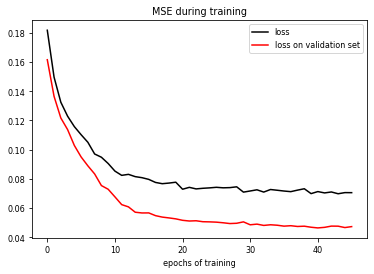

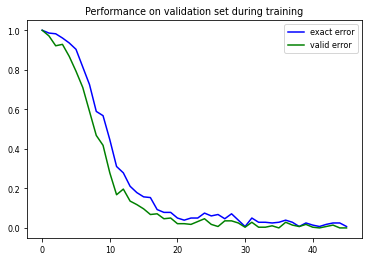

Testing on test set ...
Valid representations :  999 / 1000
Exact representations :  991 / 1000
MSE on test :  0.04593712463974953
RMSE on test :  0.21432947683356465
Testing on training set ...
Valid representations :  997 / 1000
Exact representations :  986 / 1000
MSE on test :  0.04225316643714905
RMSE on test :  0.2055557501923725


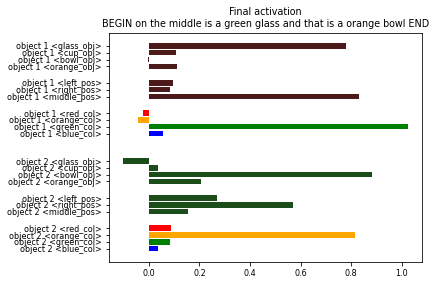

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
masking_11 (Masking)            (None, 19, 20)       0           input_12[0][0]                   
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, 19, 20), (No 3280        masking_11[0][0]                 
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 20)           0           lstm_11[0][0]                    
___________________________________________________________________________________________

Epoch 8/70
Valid representations :  126 / 280
Exact representations :  91 / 280
MSE on test :  0.07614236325025558
RMSE on test :  0.2759390571308375

Epoch 00008: val_loss improved from 0.08035 to 0.07614, saving model to saved_LSTM/best_model0.41301643683274636.hdf5
500/500 - 3s - loss: 0.0920 - val_loss: 0.0761
Epoch 9/70
Valid representations :  145 / 280
Exact representations :  115 / 280
MSE on test :  0.07319644093513489
RMSE on test :  0.2705484077482898

Epoch 00009: val_loss improved from 0.07614 to 0.07320, saving model to saved_LSTM/best_model0.41301643683274636.hdf5
500/500 - 3s - loss: 0.0896 - val_loss: 0.0732
Epoch 10/70
Valid representations :  166 / 280
Exact representations :  135 / 280
MSE on test :  0.06907720863819122
RMSE on test :  0.2628254337734292

Epoch 00010: val_loss improved from 0.07320 to 0.06908, saving model to saved_LSTM/best_model0.41301643683274636.hdf5
500/500 - 3s - loss: 0.0874 - val_loss: 0.0691
Epoch 11/70
Valid representations :  187 / 280
Ex

Epoch 36/70
Valid representations :  274 / 280
Exact representations :  265 / 280
MSE on test :  0.04853511601686478
RMSE on test :  0.22030686783862363

Epoch 00036: val_loss did not improve from 0.04736
500/500 - 3s - loss: 0.0715 - val_loss: 0.0485
Epoch 37/70
Valid representations :  277 / 280
Exact representations :  275 / 280
MSE on test :  0.04742976650595665
RMSE on test :  0.21778376088670306

Epoch 00037: val_loss did not improve from 0.04736
500/500 - 3s - loss: 0.0716 - val_loss: 0.0474
Epoch 38/70
Valid representations :  276 / 280
Exact representations :  271 / 280
MSE on test :  0.04746308922767639
RMSE on test :  0.21786025160105824

Epoch 00038: val_loss did not improve from 0.04736
500/500 - 3s - loss: 0.0703 - val_loss: 0.0475
Epoch 39/70
Valid representations :  279 / 280
Exact representations :  277 / 280
MSE on test :  0.046822886914014816
RMSE on test :  0.2163859674609581

Epoch 00039: val_loss improved from 0.04736 to 0.04682, saving model to saved_LSTM/best_mo

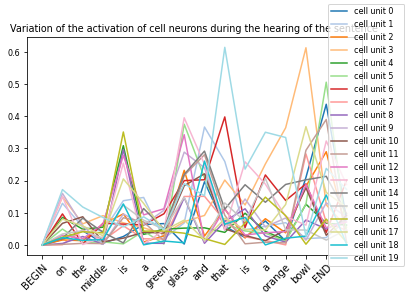

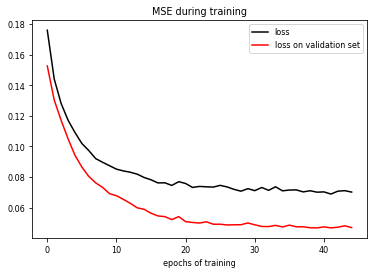

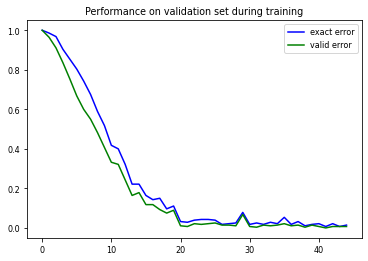

Testing on test set ...
Valid representations :  997 / 1000
Exact representations :  985 / 1000
MSE on test :  0.04552577808499336
RMSE on test :  0.21336770628422982
Testing on training set ...
Valid representations :  996 / 1000
Exact representations :  985 / 1000
MSE on test :  0.041988350450992584
RMSE on test :  0.2049105913587499


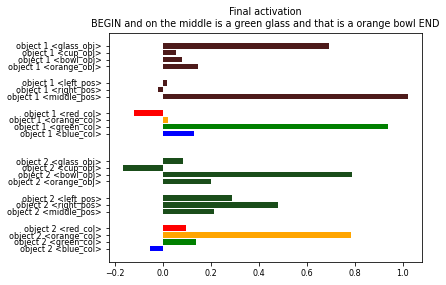

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
masking_12 (Masking)            (None, 19, 20)       0           input_13[0][0]                   
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 19, 20), (No 3280        masking_12[0][0]                 
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 20)           0           lstm_12[0][0]                    
___________________________________________________________________________________________

Epoch 8/70
Valid representations :  107 / 280
Exact representations :  61 / 280
MSE on test :  0.08537068963050842
RMSE on test :  0.2921826306105625

Epoch 00008: val_loss improved from 0.08980 to 0.08537, saving model to saved_LSTM/best_model0.8224848663752603.hdf5
500/500 - 3s - loss: 0.0987 - val_loss: 0.0854
Epoch 9/70
Valid representations :  143 / 280
Exact representations :  90 / 280
MSE on test :  0.08181837946176529
RMSE on test :  0.2860391222573676

Epoch 00009: val_loss improved from 0.08537 to 0.08182, saving model to saved_LSTM/best_model0.8224848663752603.hdf5
500/500 - 3s - loss: 0.0976 - val_loss: 0.0818
Epoch 10/70
Valid representations :  153 / 280
Exact representations :  105 / 280
MSE on test :  0.07597370445728302
RMSE on test :  0.27563327893649386

Epoch 00010: val_loss improved from 0.08182 to 0.07597, saving model to saved_LSTM/best_model0.8224848663752603.hdf5
500/500 - 3s - loss: 0.0924 - val_loss: 0.0760
Epoch 11/70
Valid representations :  189 / 280
Exact

Epoch 35/70
Valid representations :  274 / 280
Exact representations :  272 / 280
MSE on test :  0.04941069707274437
RMSE on test :  0.22228517060916225

Epoch 00035: val_loss did not improve from 0.04798
500/500 - 3s - loss: 0.0720 - val_loss: 0.0494
Epoch 36/70
Valid representations :  274 / 280
Exact representations :  269 / 280
MSE on test :  0.04813246801495552
RMSE on test :  0.21939113021030618

Epoch 00036: val_loss did not improve from 0.04798
500/500 - 3s - loss: 0.0714 - val_loss: 0.0481
Epoch 37/70
Valid representations :  277 / 280
Exact representations :  270 / 280
MSE on test :  0.047012314200401306
RMSE on test :  0.21682323261219336

Epoch 00037: val_loss improved from 0.04798 to 0.04701, saving model to saved_LSTM/best_model0.8224848663752603.hdf5
500/500 - 3s - loss: 0.0721 - val_loss: 0.0470
Epoch 38/70
Valid representations :  277 / 280
Exact representations :  275 / 280
MSE on test :  0.04876023158431053
RMSE on test :  0.22081719041847836

Epoch 00038: val_loss d

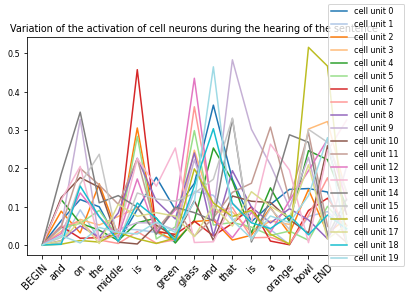

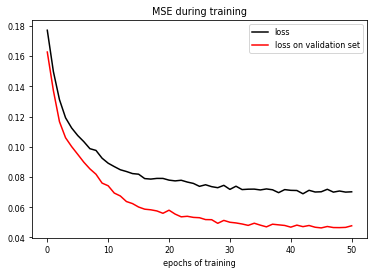

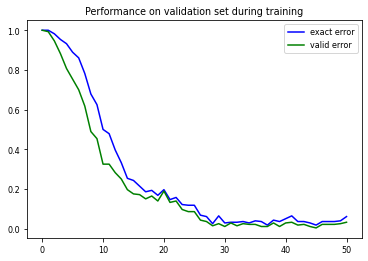

Testing on test set ...
Valid representations :  965 / 1000
Exact representations :  946 / 1000
MSE on test :  0.046781279146671295
RMSE on test :  0.21628980361235547
Testing on training set ...
Valid representations :  969 / 1000
Exact representations :  941 / 1000
MSE on test :  0.042853400111198425
RMSE on test :  0.20701062801508144


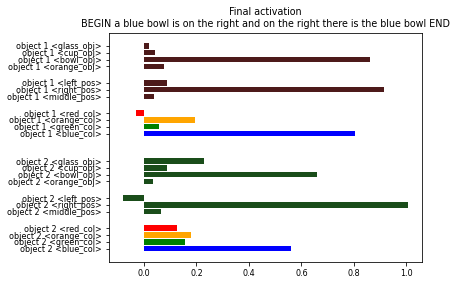

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
masking_13 (Masking)            (None, 19, 20)       0           input_14[0][0]                   
__________________________________________________________________________________________________
lstm_13 (LSTM)                  [(None, 19, 20), (No 3280        masking_13[0][0]                 
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 20)           0           lstm_13[0][0]                    
___________________________________________________________________________________________

Epoch 8/70
Valid representations :  111 / 280
Exact representations :  72 / 280
MSE on test :  0.08100100606679916
RMSE on test :  0.28460675688886794

Epoch 00008: val_loss improved from 0.08598 to 0.08100, saving model to saved_LSTM/best_model0.8916518387362329.hdf5
500/500 - 3s - loss: 0.0970 - val_loss: 0.0810
Epoch 9/70
Valid representations :  135 / 280
Exact representations :  100 / 280
MSE on test :  0.07372910529375076
RMSE on test :  0.2715310392823457

Epoch 00009: val_loss improved from 0.08100 to 0.07373, saving model to saved_LSTM/best_model0.8916518387362329.hdf5
500/500 - 3s - loss: 0.0931 - val_loss: 0.0737
Epoch 10/70
Valid representations :  176 / 280
Exact representations :  133 / 280
MSE on test :  0.07184424996376038
RMSE on test :  0.26803777712061483

Epoch 00010: val_loss improved from 0.07373 to 0.07184, saving model to saved_LSTM/best_model0.8916518387362329.hdf5
500/500 - 3s - loss: 0.0893 - val_loss: 0.0718
Epoch 11/70
Valid representations :  198 / 280
Exa

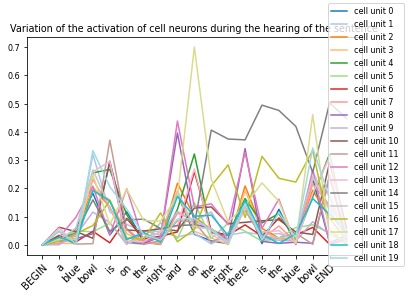

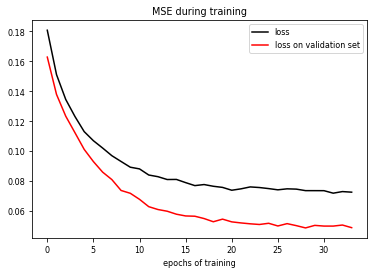

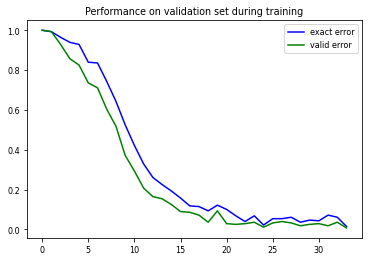

Testing on test set ...
Valid representations :  994 / 1000
Exact representations :  985 / 1000
MSE on test :  0.04777960851788521
RMSE on test :  0.21858547188201966
Testing on training set ...
Valid representations :  990 / 1000
Exact representations :  981 / 1000
MSE on test :  0.04436339810490608
RMSE on test :  0.21062620469662857


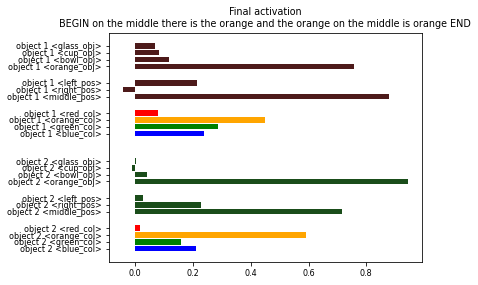

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
masking_14 (Masking)            (None, 19, 20)       0           input_15[0][0]                   
__________________________________________________________________________________________________
lstm_14 (LSTM)                  [(None, 19, 20), (No 3280        masking_14[0][0]                 
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 20)           0           lstm_14[0][0]                    
___________________________________________________________________________________________

Epoch 8/70
Valid representations :  134 / 280
Exact representations :  93 / 280
MSE on test :  0.07961812615394592
RMSE on test :  0.2821668409894152

Epoch 00008: val_loss improved from 0.08682 to 0.07962, saving model to saved_LSTM/best_model0.5639368640152379.hdf5
500/500 - 3s - loss: 0.0966 - val_loss: 0.0796
Epoch 9/70
Valid representations :  161 / 280
Exact representations :  121 / 280
MSE on test :  0.07375341653823853
RMSE on test :  0.27157580256392233

Epoch 00009: val_loss improved from 0.07962 to 0.07375, saving model to saved_LSTM/best_model0.5639368640152379.hdf5
500/500 - 3s - loss: 0.0910 - val_loss: 0.0738
Epoch 10/70
Valid representations :  179 / 280
Exact representations :  150 / 280
MSE on test :  0.06942443549633026
RMSE on test :  0.2634851713025427

Epoch 00010: val_loss improved from 0.07375 to 0.06942, saving model to saved_LSTM/best_model0.5639368640152379.hdf5
500/500 - 3s - loss: 0.0882 - val_loss: 0.0694
Epoch 11/70
Valid representations :  199 / 280
Exac

Epoch 37/70
Valid representations :  276 / 280
Exact representations :  275 / 280
MSE on test :  0.047496456652879715
RMSE on test :  0.21793681802962922

Epoch 00037: val_loss improved from 0.04750 to 0.04750, saving model to saved_LSTM/best_model0.5639368640152379.hdf5
500/500 - 3s - loss: 0.0703 - val_loss: 0.0475
Epoch 38/70
Valid representations :  278 / 280
Exact representations :  274 / 280
MSE on test :  0.0474909171462059
RMSE on test :  0.21792410868512438

Epoch 00038: val_loss improved from 0.04750 to 0.04749, saving model to saved_LSTM/best_model0.5639368640152379.hdf5
500/500 - 3s - loss: 0.0719 - val_loss: 0.0475
Epoch 39/70
Valid representations :  280 / 280
Exact representations :  277 / 280
MSE on test :  0.04706915467977524
RMSE on test :  0.21695426863690706

Epoch 00039: val_loss improved from 0.04749 to 0.04707, saving model to saved_LSTM/best_model0.5639368640152379.hdf5
500/500 - 3s - loss: 0.0693 - val_loss: 0.0471
Epoch 40/70
Valid representations :  277 / 280

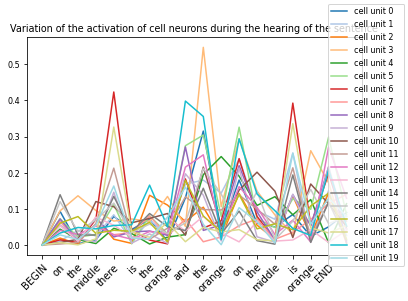

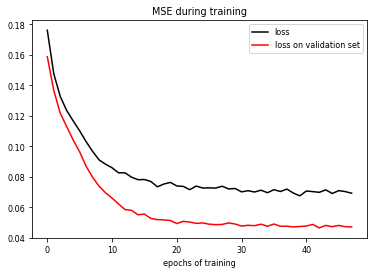

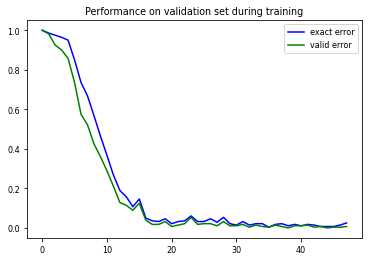

Testing on test set ...
Valid representations :  992 / 1000
Exact representations :  977 / 1000
MSE on test :  0.0458025299012661
RMSE on test :  0.21401525623484438
Testing on training set ...
Valid representations :  994 / 1000
Exact representations :  980 / 1000
MSE on test :  0.042265161871910095
RMSE on test :  0.20558492617872084


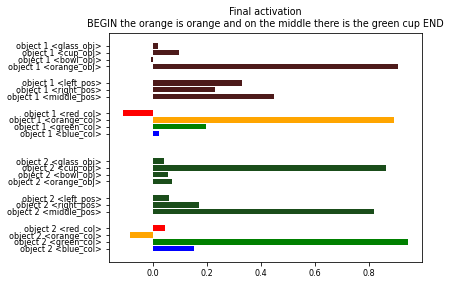

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


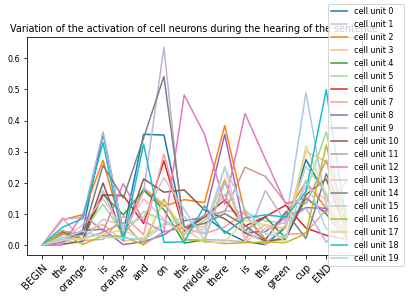

In [25]:
test_version = True
if __name__ == "__main__":
    for i in np.arange(5):
        if use_save_version:
            model = keras.models.load_model(path + "best_model"+rand_id+".hdf5")
            if test_version:
                model_for_test = keras.models.load_model(path + "best_model_for_test"+rand_id+".hdf5")

        else:
            rand_id = str(np.random.random()) #random id used for the file names during the model save

            #build the model
            if test_version:
                inp = Input((max_seq_len, nb_unique_words))
                masked = Masking(mask_value=special_value)(inp)
                lstm_out, state_h, state_c = LSTM(lstm_units, return_state = True, dropout = dropout, return_sequences=True)(masked)
                attention_weights, attention_output = Attention(20)(lstm_out)
                output_to_train = Dense(output_size)(attention_output)

                model = Model(inputs = inp, outputs = output_to_train)
                model_for_test = Model(inputs = inp, outputs = [output_to_train, state_h, state_c])
                model.compile(loss='mean_squared_error', optimizer='adam')
                model_for_test.compile(loss='mean_squared_error', optimizer='adam')

                if verbose_training:
                    print("model for hidden states: ", model_for_test.summary())
            else:
                model = Sequential()
                model.add(Masking(mask_value=special_value, input_shape=(max_seq_len, nb_unique_words)))
                model.add(LSTM(lstm_units, stateful=False, return_sequences=True))
                model.add(Attention(32))
                model.add(Dense(output_size))
                model.compile(loss='mean_squared_error', optimizer='adam')

            if verbose_training:
                print(model.summary()) # print the architecture of the model

            if not(minimal_mode):
                history = LossHistory() #to get the evolution of the loss during training
                checkpoint = ModelCheckpoint("saved_LSTM/best_model"+rand_id+".hdf5",
                                            monitor='val_loss', verbose=1,
                                            mode='auto', period=1, save_best_only = True) #we save the model after each epoch of training
                earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

            t1 = time.process_time()

            #training
            if minimal_mode:
                model.fit(trainX_pad, trainY, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
            else:
                model.fit(trainX_pad, trainY, epochs=nb_epoch, batch_size=batch_size, verbose=2, shuffle=False, callbacks=[history, checkpoint, earlystopping], validation_data=(validationX_pad, validationY))


            t2 = time.process_time()

            if verbose_training:
                print("End of training !")
                print("CPU Time to train : ", t2 -t1)
            if not(minimal_mode):
                model_for_test.save("saved_LSTM/best_model_for_test"+rand_id+".hdf5")
                history.plot_loss()


        if verbose_training:
            print("Testing on test set ...")
        v, ex, er = test_on_test_set(model, testX_pad , testY, test_sentences, verbose_training, threshold_factor)
        if minimal_mode:
            print(str(nb_objects) + "," +str(v) + "," + str(ex) + ","+ str(er) + "," + str(t2-t1))

        if not(minimal_mode):
            if verbose_training:
                print("Testing on training set ...")
            v, ex, er = test_on_test_set(model, trainX_pad , trainY, train_sentences, True, threshold_factor)


        #qualitative analysis of the output of the LSTM
        if not(minimal_mode):
            test_sent = ["BEGIN on the middle is a green glass and that is a orange bowl END", #0
            "BEGIN and on the middle is a green glass and that is a orange bowl END",
            "BEGIN a blue bowl is on the right and on the right there is the blue bowl END",
            "BEGIN on the middle there is the orange and the orange on the middle is orange END", #3
            "BEGIN the orange is orange and on the middle there is the green cup END",
            "BEGIN on the left there is a blue glass and this is a orange END",
            "BEGIN the glass on the left is blue and the bowl on the right is green END", #6
            "BEGIN the orange on the right is green and there is a blue cup on the middle END",
            "BEGIN on the right there is a red glass and the cup on the middle is red END",
            "BEGIN a green glass is on the right and on the left is a orange END"] #9

            #plot the final outputs on a test sentence
            outputs = test_with_sentences(test_sent , model)
            ind = i
            plot_final_activation(outputs[ind],
                                concepts_delimitations,
                                output_id_to_concept_dict,
                                nb_concepts,
                                test_sent[ind])

            #plot and save to png the evolution of the LSTM outputs during the processing of a sentence
            s = test_sent[ind]
            suc_outputs = get_successive_outputs(s, model)
            plot_concept_activation(s,
                                    suc_outputs,
                                    concepts_delimitations,
                                    nb_concepts,
                                    savefig = True,
                                    sub_ttl_fig = s + " LSTM")


            #plot the evolution of cell activity
            activations = get_successive_outputs(s, model_for_test)
            plot_hidden_states(s,
                            model_for_test,
                            units_to_plot = 'all',
                            state = 'cell',
                            plt_var = True,
                            plt_sum = False)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
masking_5 (Masking)             (None, 19, 20)       0           input_6[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 19, 40), (No 9760        masking_5[0][0]                  
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 40)           0           lstm_5[0][0]                     
___________________________________________________________________________________________

Epoch 8/70
Valid representations :  257 / 280
Exact representations :  245 / 280
MSE on test :  0.055987682193517685
RMSE on test :  0.23661716377625205

Epoch 00008: val_loss improved from 0.05944 to 0.05599, saving model to saved_LSTM/best_model0.23062202657802267.hdf5
500/500 - 3s - loss: 0.0778 - val_loss: 0.0560
Epoch 9/70
Valid representations :  254 / 280
Exact representations :  249 / 280
MSE on test :  0.05544568598270416
RMSE on test :  0.23546907648925827

Epoch 00009: val_loss improved from 0.05599 to 0.05545, saving model to saved_LSTM/best_model0.23062202657802267.hdf5
500/500 - 3s - loss: 0.0758 - val_loss: 0.0554
Epoch 10/70
Valid representations :  267 / 280
Exact representations :  263 / 280
MSE on test :  0.05547736585140228
RMSE on test :  0.2355363365839808

Epoch 00010: val_loss did not improve from 0.05545
500/500 - 3s - loss: 0.0768 - val_loss: 0.0555
Epoch 11/70
Valid representations :  267 / 280
Exact representations :  264 / 280
MSE on test :  0.0522371828556

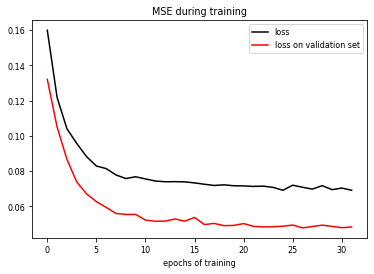

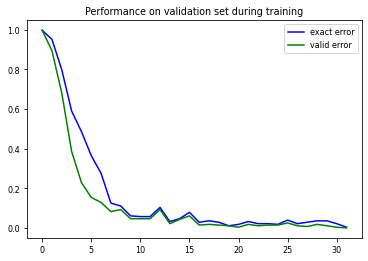

Testing on test set ...
Valid representations :  989 / 1000
Exact representations :  980 / 1000
MSE on test :  0.04701998084783554
RMSE on test :  0.21684091137936942
Testing on training set ...
Valid representations :  994 / 1000
Exact representations :  982 / 1000
MSE on test :  0.042178016155958176
RMSE on test :  0.2053728710320771


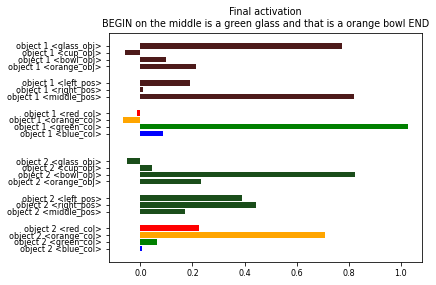

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
masking_6 (Masking)             (None, 19, 20)       0           input_7[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 19, 40), (No 9760        masking_6[0][0]                  
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 40)           0           lstm_6[0][0]                     
___________________________________________________________________________________________

Epoch 8/70
Valid representations :  253 / 280
Exact representations :  226 / 280
MSE on test :  0.058302540332078934
RMSE on test :  0.24145918978593242

Epoch 00008: val_loss improved from 0.06260 to 0.05830, saving model to saved_LSTM/best_model0.6271940125450822.hdf5
500/500 - 3s - loss: 0.0787 - val_loss: 0.0583
Epoch 9/70
Valid representations :  255 / 280
Exact representations :  247 / 280
MSE on test :  0.05547211691737175
RMSE on test :  0.23552519380603798

Epoch 00009: val_loss improved from 0.05830 to 0.05547, saving model to saved_LSTM/best_model0.6271940125450822.hdf5
500/500 - 3s - loss: 0.0768 - val_loss: 0.0555
Epoch 10/70
Valid representations :  269 / 280
Exact representations :  260 / 280
MSE on test :  0.05497506633400917
RMSE on test :  0.23446762321056008

Epoch 00010: val_loss improved from 0.05547 to 0.05498, saving model to saved_LSTM/best_model0.6271940125450822.hdf5
500/500 - 3s - loss: 0.0768 - val_loss: 0.0550
Epoch 11/70
Valid representations :  265 / 280


Epoch 37/70
Valid representations :  276 / 280
Exact representations :  274 / 280
MSE on test :  0.04799983277916908
RMSE on test :  0.21908864137414583

Epoch 00037: val_loss improved from 0.04851 to 0.04800, saving model to saved_LSTM/best_model0.6271940125450822.hdf5
500/500 - 3s - loss: 0.0712 - val_loss: 0.0480
Epoch 38/70
Valid representations :  276 / 280
Exact representations :  274 / 280
MSE on test :  0.048291951417922974
RMSE on test :  0.21975429783720493

Epoch 00038: val_loss did not improve from 0.04800
500/500 - 3s - loss: 0.0685 - val_loss: 0.0483
Epoch 39/70
Valid representations :  275 / 280
Exact representations :  271 / 280
MSE on test :  0.04909568279981613
RMSE on test :  0.22157545622161343

Epoch 00039: val_loss did not improve from 0.04800
500/500 - 3s - loss: 0.0718 - val_loss: 0.0491
Epoch 40/70
Valid representations :  274 / 280
Exact representations :  272 / 280
MSE on test :  0.04940483346581459
RMSE on test :  0.2222719808383742

Epoch 00040: val_loss di

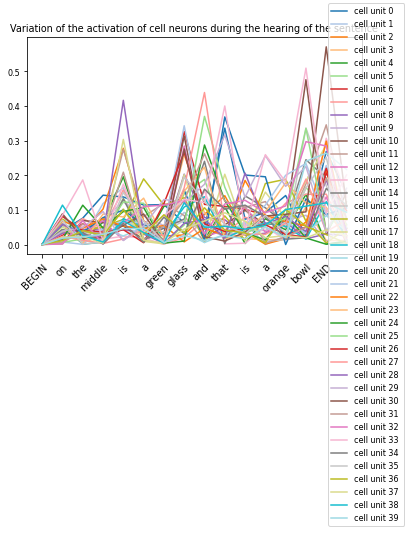

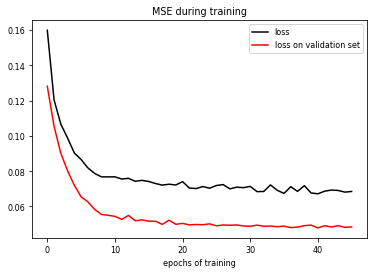

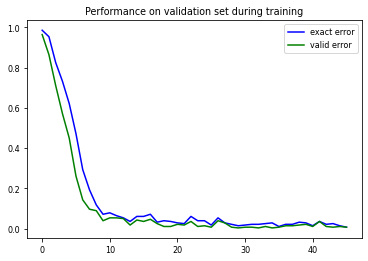

Testing on test set ...
Valid representations :  994 / 1000
Exact representations :  987 / 1000
MSE on test :  0.04697408527135849
RMSE on test :  0.21673505778105787
Testing on training set ...
Valid representations :  999 / 1000
Exact representations :  985 / 1000
MSE on test :  0.04091634973883629
RMSE on test :  0.20227790225043438


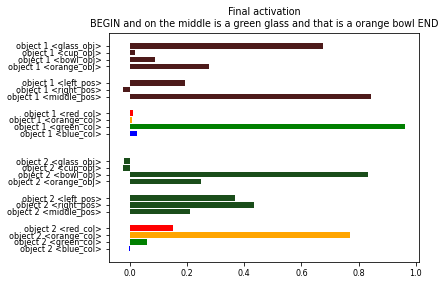

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
masking_7 (Masking)             (None, 19, 20)       0           input_8[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 19, 40), (No 9760        masking_7[0][0]                  
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 40)           0           lstm_7[0][0]                     
___________________________________________________________________________________________

Epoch 8/70
Valid representations :  265 / 280
Exact representations :  250 / 280
MSE on test :  0.05546465516090393
RMSE on test :  0.23550935259752198

Epoch 00008: val_loss improved from 0.05844 to 0.05546, saving model to saved_LSTM/best_model0.3469036871408602.hdf5
500/500 - 3s - loss: 0.0796 - val_loss: 0.0555
Epoch 9/70
Valid representations :  270 / 280
Exact representations :  265 / 280
MSE on test :  0.05411534011363983
RMSE on test :  0.23262704080488972

Epoch 00009: val_loss improved from 0.05546 to 0.05412, saving model to saved_LSTM/best_model0.3469036871408602.hdf5
500/500 - 3s - loss: 0.0778 - val_loss: 0.0541
Epoch 10/70
Valid representations :  274 / 280
Exact representations :  269 / 280
MSE on test :  0.053078874945640564
RMSE on test :  0.2303885304125198

Epoch 00010: val_loss improved from 0.05412 to 0.05308, saving model to saved_LSTM/best_model0.3469036871408602.hdf5
500/500 - 3s - loss: 0.0759 - val_loss: 0.0531
Epoch 11/70
Valid representations :  273 / 280
E

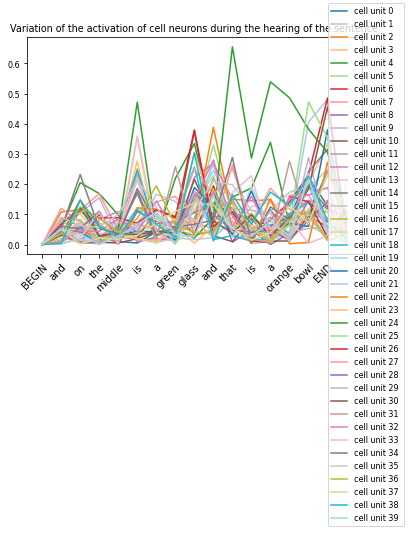

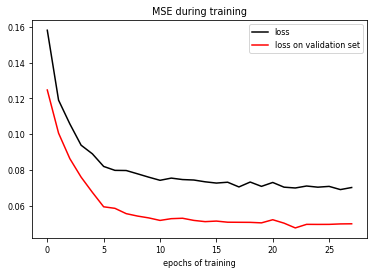

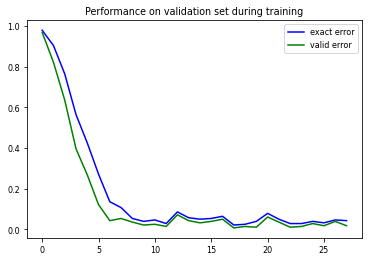

Testing on test set ...
Valid representations :  981 / 1000
Exact representations :  965 / 1000
MSE on test :  0.048433877527713776
RMSE on test :  0.22007698091284736
Testing on training set ...
Valid representations :  992 / 1000
Exact representations :  959 / 1000
MSE on test :  0.04353370517492294
RMSE on test :  0.20864732247245096


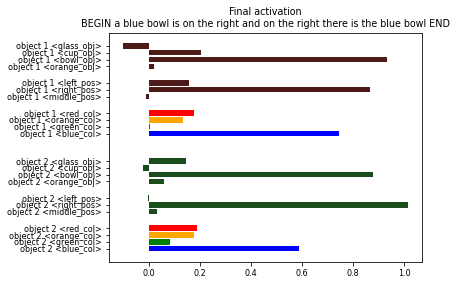

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
masking_8 (Masking)             (None, 19, 20)       0           input_9[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 19, 40), (No 9760        masking_8[0][0]                  
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 40)           0           lstm_8[0][0]                     
___________________________________________________________________________________________

Epoch 8/70
Valid representations :  247 / 280
Exact representations :  231 / 280
MSE on test :  0.05830150470137596
RMSE on test :  0.2414570452510673

Epoch 00008: val_loss did not improve from 0.05793
500/500 - 3s - loss: 0.0796 - val_loss: 0.0583
Epoch 9/70
Valid representations :  268 / 280
Exact representations :  259 / 280
MSE on test :  0.055889029055833817
RMSE on test :  0.23640860613741163

Epoch 00009: val_loss improved from 0.05793 to 0.05589, saving model to saved_LSTM/best_model0.7649012005631963.hdf5
500/500 - 3s - loss: 0.0770 - val_loss: 0.0559
Epoch 10/70
Valid representations :  268 / 280
Exact representations :  260 / 280
MSE on test :  0.055276889353990555
RMSE on test :  0.2351103769593987

Epoch 00010: val_loss improved from 0.05589 to 0.05528, saving model to saved_LSTM/best_model0.7649012005631963.hdf5
500/500 - 3s - loss: 0.0772 - val_loss: 0.0553
Epoch 11/70
Valid representations :  277 / 280
Exact representations :  263 / 280
MSE on test :  0.053453408181667

Epoch 37/70
Valid representations :  274 / 280
Exact representations :  273 / 280
MSE on test :  0.0485885813832283
RMSE on test :  0.22042817738036194

Epoch 00037: val_loss did not improve from 0.04702
500/500 - 3s - loss: 0.0693 - val_loss: 0.0486
Epoch 38/70
Valid representations :  279 / 280
Exact representations :  276 / 280
MSE on test :  0.04805827885866165
RMSE on test :  0.21922198534513287

Epoch 00038: val_loss did not improve from 0.04702
500/500 - 3s - loss: 0.0674 - val_loss: 0.0481
Epoch 39/70
Valid representations :  276 / 280
Exact representations :  273 / 280
MSE on test :  0.04855741187930107
RMSE on test :  0.22035746386111152

Epoch 00039: val_loss did not improve from 0.04702
500/500 - 3s - loss: 0.0681 - val_loss: 0.0486
Epoch 40/70
Valid representations :  268 / 280
Exact representations :  265 / 280
MSE on test :  0.04918280988931656
RMSE on test :  0.22177197724085104

Epoch 00040: val_loss did not improve from 0.04702
500/500 - 3s - loss: 0.0691 - val_loss: 

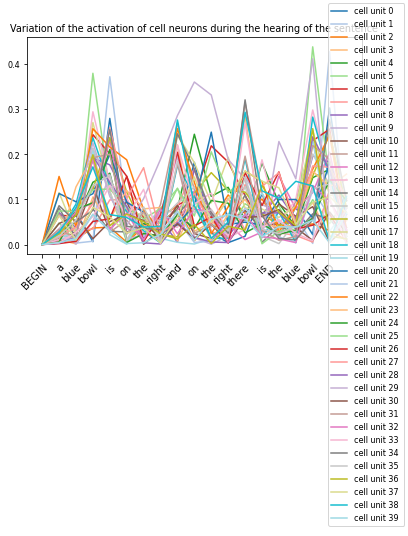

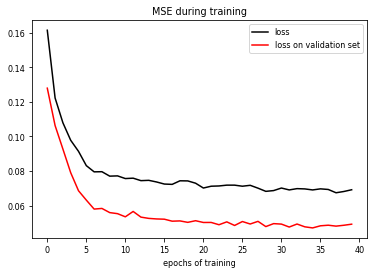

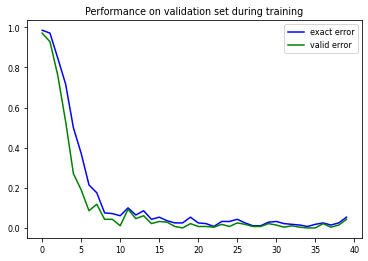

Testing on test set ...
Valid representations :  964 / 1000
Exact representations :  941 / 1000
MSE on test :  0.048089027404785156
RMSE on test :  0.21929210520396114
Testing on training set ...
Valid representations :  989 / 1000
Exact representations :  964 / 1000
MSE on test :  0.042425744235515594
RMSE on test :  0.20597510586358633


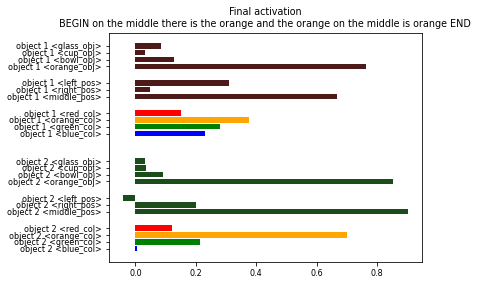

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
masking_9 (Masking)             (None, 19, 20)       0           input_10[0][0]                   
__________________________________________________________________________________________________
lstm_9 (LSTM)                   [(None, 19, 40), (No 9760        masking_9[0][0]                  
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 40)           0           lstm_9[0][0]                     
___________________________________________________________________________________________

Epoch 8/70
Valid representations :  262 / 280
Exact representations :  256 / 280
MSE on test :  0.057747069746255875
RMSE on test :  0.24030619997464875

Epoch 00008: val_loss improved from 0.05802 to 0.05775, saving model to saved_LSTM/best_model0.7913476311788556.hdf5
500/500 - 3s - loss: 0.0766 - val_loss: 0.0577
Epoch 9/70
Valid representations :  266 / 280
Exact representations :  258 / 280
MSE on test :  0.055474184453487396
RMSE on test :  0.23552958296886486

Epoch 00009: val_loss improved from 0.05775 to 0.05547, saving model to saved_LSTM/best_model0.7913476311788556.hdf5
500/500 - 3s - loss: 0.0771 - val_loss: 0.0555
Epoch 10/70
Valid representations :  255 / 280
Exact representations :  250 / 280
MSE on test :  0.05673735961318016
RMSE on test :  0.2381960528916887

Epoch 00010: val_loss did not improve from 0.05547
500/500 - 3s - loss: 0.0750 - val_loss: 0.0567
Epoch 11/70
Valid representations :  261 / 280
Exact representations :  256 / 280
MSE on test :  0.05232416465878

Epoch 37/70
Valid representations :  278 / 280
Exact representations :  273 / 280
MSE on test :  0.04848111793398857
RMSE on test :  0.22018428175959467

Epoch 00037: val_loss did not improve from 0.04711
500/500 - 3s - loss: 0.0695 - val_loss: 0.0485
Epoch 38/70
Valid representations :  279 / 280
Exact representations :  274 / 280
MSE on test :  0.04813472926616669
RMSE on test :  0.2193962836197703

Epoch 00038: val_loss did not improve from 0.04711
500/500 - 3s - loss: 0.0693 - val_loss: 0.0481
Epoch 39/70
Valid representations :  275 / 280
Exact representations :  269 / 280
MSE on test :  0.048091307282447815
RMSE on test :  0.2192973034089745

Epoch 00039: val_loss did not improve from 0.04711
500/500 - 3s - loss: 0.0689 - val_loss: 0.0481
Epoch 00039: early stopping
End of training !
CPU Time to train :  342.8463363189999


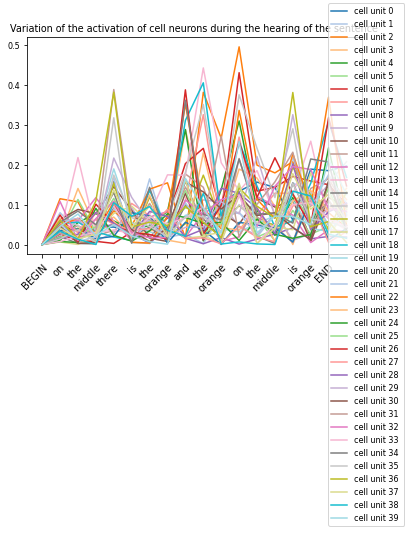

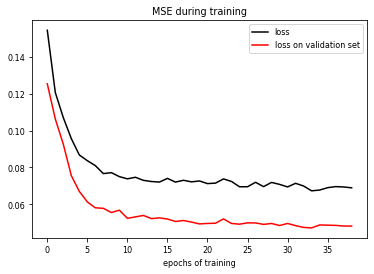

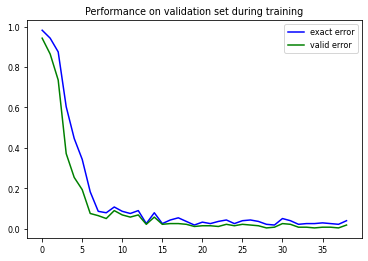

Testing on test set ...
Valid representations :  988 / 1000
Exact representations :  967 / 1000
MSE on test :  0.04664231836795807
RMSE on test :  0.21596832723331927
Testing on training set ...
Valid representations :  992 / 1000
Exact representations :  969 / 1000
MSE on test :  0.04096825420856476
RMSE on test :  0.20240616148863838


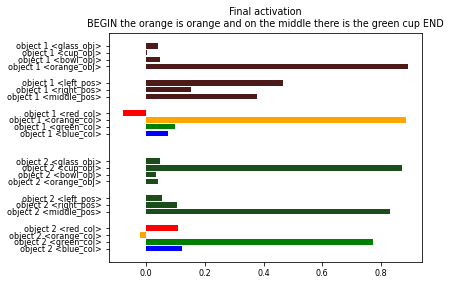

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


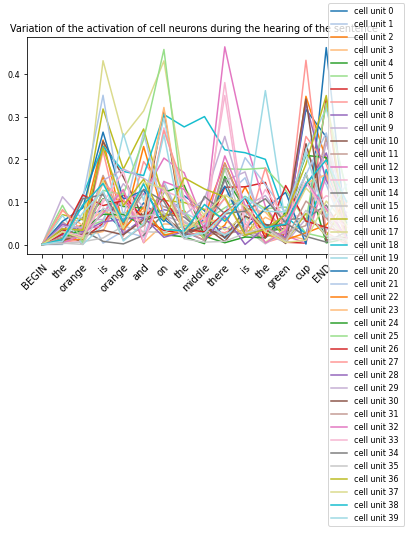

In [23]:
test_version = True
if __name__ == "__main__":
    for i in np.arange(5):
        if use_save_version:
            model = keras.models.load_model(path + "best_model"+rand_id+".hdf5")
            if test_version:
                model_for_test = keras.models.load_model(path + "best_model_for_test"+rand_id+".hdf5")

        else:
            rand_id = str(np.random.random()) #random id used for the file names during the model save

            #build the model
            if test_version:
                inp = Input((max_seq_len, nb_unique_words))
                masked = Masking(mask_value=special_value)(inp)
                lstm_out, state_h, state_c = LSTM(lstm_units, return_state = True, dropout = dropout, return_sequences=True)(masked)
                attention_weights, attention_output = Attention(40)(lstm_out)
                output_to_train = Dense(output_size)(attention_output)

                model = Model(inputs = inp, outputs = output_to_train)
                model_for_test = Model(inputs = inp, outputs = [output_to_train, state_h, state_c])
                model.compile(loss='mean_squared_error', optimizer='adam')
                model_for_test.compile(loss='mean_squared_error', optimizer='adam')

                if verbose_training:
                    print("model for hidden states: ", model_for_test.summary())
            else:
                model = Sequential()
                model.add(Masking(mask_value=special_value, input_shape=(max_seq_len, nb_unique_words)))
                model.add(LSTM(lstm_units, stateful=False, return_sequences=True))
                model.add(Attention(32))
                model.add(Dense(output_size))
                model.compile(loss='mean_squared_error', optimizer='adam')

            if verbose_training:
                print(model.summary()) # print the architecture of the model

            if not(minimal_mode):
                history = LossHistory() #to get the evolution of the loss during training
                checkpoint = ModelCheckpoint("saved_LSTM/best_model"+rand_id+".hdf5",
                                            monitor='val_loss', verbose=1,
                                            mode='auto', period=1, save_best_only = True) #we save the model after each epoch of training
                earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

            t1 = time.process_time()

            #training
            if minimal_mode:
                model.fit(trainX_pad, trainY, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
            else:
                model.fit(trainX_pad, trainY, epochs=nb_epoch, batch_size=batch_size, verbose=2, shuffle=False, callbacks=[history, checkpoint, earlystopping], validation_data=(validationX_pad, validationY))


            t2 = time.process_time()

            if verbose_training:
                print("End of training !")
                print("CPU Time to train : ", t2 -t1)
            if not(minimal_mode):
                model_for_test.save("saved_LSTM/best_model_for_test"+rand_id+".hdf5")
                history.plot_loss()


        if verbose_training:
            print("Testing on test set ...")
        v, ex, er = test_on_test_set(model, testX_pad , testY, test_sentences, verbose_training, threshold_factor)
        if minimal_mode:
            print(str(nb_objects) + "," +str(v) + "," + str(ex) + ","+ str(er) + "," + str(t2-t1))

        if not(minimal_mode):
            if verbose_training:
                print("Testing on training set ...")
            v, ex, er = test_on_test_set(model, trainX_pad , trainY, train_sentences, True, threshold_factor)


        #qualitative analysis of the output of the LSTM
        if not(minimal_mode):
            test_sent = ["BEGIN on the middle is a green glass and that is a orange bowl END", #0
            "BEGIN and on the middle is a green glass and that is a orange bowl END",
            "BEGIN a blue bowl is on the right and on the right there is the blue bowl END",
            "BEGIN on the middle there is the orange and the orange on the middle is orange END", #3
            "BEGIN the orange is orange and on the middle there is the green cup END",
            "BEGIN on the left there is a blue glass and this is a orange END",
            "BEGIN the glass on the left is blue and the bowl on the right is green END", #6
            "BEGIN the orange on the right is green and there is a blue cup on the middle END",
            "BEGIN on the right there is a red glass and the cup on the middle is red END",
            "BEGIN a green glass is on the right and on the left is a orange END"] #9

            #plot the final outputs on a test sentence
            outputs = test_with_sentences(test_sent , model)
            ind = i
            plot_final_activation(outputs[ind],
                                concepts_delimitations,
                                output_id_to_concept_dict,
                                nb_concepts,
                                test_sent[ind])

            #plot and save to png the evolution of the LSTM outputs during the processing of a sentence
            s = test_sent[ind]
            suc_outputs = get_successive_outputs(s, model)
            plot_concept_activation(s,
                                    suc_outputs,
                                    concepts_delimitations,
                                    nb_concepts,
                                    savefig = True,
                                    sub_ttl_fig = s + " LSTM")


            #plot the evolution of cell activity
            activations = get_successive_outputs(s, model_for_test)
            plot_hidden_states(s,
                            model_for_test,
                            units_to_plot = 'all',
                            state = 'cell',
                            plt_var = True,
                            plt_sum = False)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 19, 20)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 19, 80), (No 32320       masking[0][0]                    
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 80)           0           lstm[0][0]                       
____________________________________________________________________________________________

Epoch 8/70
Valid representations :  267 / 280
Exact representations :  255 / 280
MSE on test :  0.05527273565530777
RMSE on test :  0.2351015432856785

Epoch 00008: val_loss improved from 0.05863 to 0.05527, saving model to saved_LSTM/best_model0.3094655479039021.hdf5
500/500 - 3s - loss: 0.0789 - val_loss: 0.0553
Epoch 9/70
Valid representations :  271 / 280
Exact representations :  255 / 280
MSE on test :  0.05534558370709419
RMSE on test :  0.2352564211814296

Epoch 00009: val_loss did not improve from 0.05527
500/500 - 3s - loss: 0.0776 - val_loss: 0.0553
Epoch 10/70
Valid representations :  261 / 280
Exact representations :  249 / 280
MSE on test :  0.05554575100541115
RMSE on test :  0.2356814608861103

Epoch 00010: val_loss did not improve from 0.05527
500/500 - 3s - loss: 0.0753 - val_loss: 0.0555
Epoch 11/70
Valid representations :  270 / 280
Exact representations :  261 / 280
MSE on test :  0.0536947026848793
RMSE on test :  0.2317211744422147

Epoch 00011: val_loss improved 

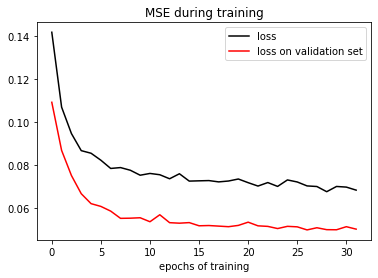

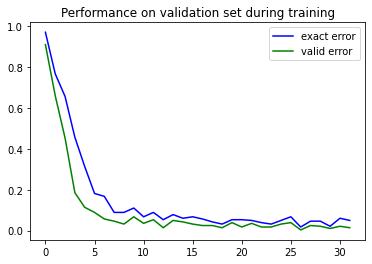

Testing on test set ...
Valid representations :  984 / 1000
Exact representations :  940 / 1000
MSE on test :  0.04914466291666031
RMSE on test :  0.22168595561437876
Testing on training set ...
Valid representations :  998 / 1000
Exact representations :  950 / 1000
MSE on test :  0.04251112788915634
RMSE on test :  0.20618226860997613


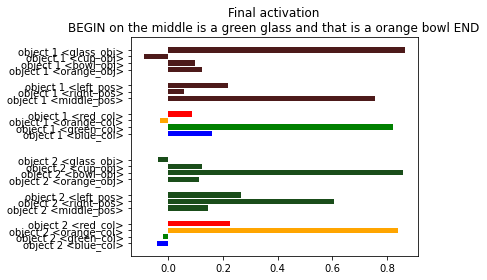

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 19, 20)       0           input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 19, 80), (No 32320       masking_1[0][0]                  
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 80)           0           lstm_1[0][0]                     
____________________________________________________________________________________________

Epoch 8/70
Valid representations :  242 / 280
Exact representations :  214 / 280
MSE on test :  0.061903245747089386
RMSE on test :  0.24880362888649632

Epoch 00008: val_loss did not improve from 0.05978
500/500 - 3s - loss: 0.0796 - val_loss: 0.0619
Epoch 9/70
Valid representations :  266 / 280
Exact representations :  262 / 280
MSE on test :  0.056329090148210526
RMSE on test :  0.23733750261644393

Epoch 00009: val_loss improved from 0.05978 to 0.05633, saving model to saved_LSTM/best_model0.044863784444827526.hdf5
500/500 - 3s - loss: 0.0769 - val_loss: 0.0563
Epoch 10/70
Valid representations :  266 / 280
Exact representations :  261 / 280
MSE on test :  0.05549228563904762
RMSE on test :  0.23556800639952707

Epoch 00010: val_loss improved from 0.05633 to 0.05549, saving model to saved_LSTM/best_model0.044863784444827526.hdf5
500/500 - 3s - loss: 0.0754 - val_loss: 0.0555
Epoch 11/70
Valid representations :  273 / 280
Exact representations :  266 / 280
MSE on test :  0.054473653

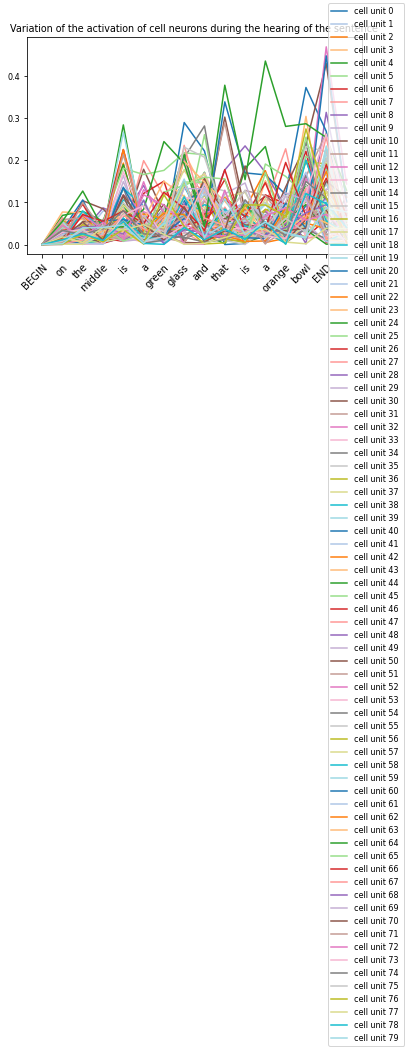

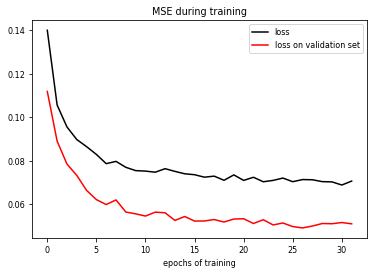

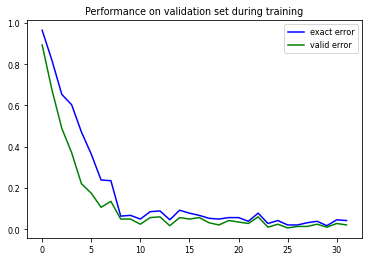

Testing on test set ...
Valid representations :  980 / 1000
Exact representations :  959 / 1000
MSE on test :  0.04972110688686371
RMSE on test :  0.22298230173460787
Testing on training set ...
Valid representations :  994 / 1000
Exact representations :  965 / 1000
MSE on test :  0.043088149279356
RMSE on test :  0.20757685150169322


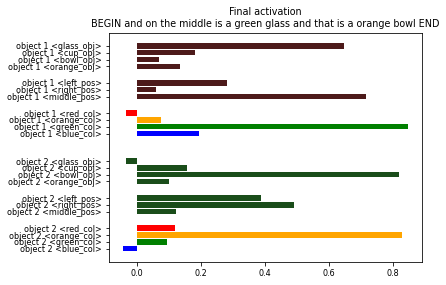

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
masking_2 (Masking)             (None, 19, 20)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 19, 80), (No 32320       masking_2[0][0]                  
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 80)           0           lstm_2[0][0]                     
____________________________________________________________________________________________

Epoch 8/70
Valid representations :  261 / 280
Exact representations :  246 / 280
MSE on test :  0.056958913803100586
RMSE on test :  0.2386606666442977

Epoch 00008: val_loss improved from 0.05806 to 0.05696, saving model to saved_LSTM/best_model0.9949386171603831.hdf5
500/500 - 3s - loss: 0.0774 - val_loss: 0.0570
Epoch 9/70
Valid representations :  274 / 280
Exact representations :  269 / 280
MSE on test :  0.053989920765161514
RMSE on test :  0.23235731269999124

Epoch 00009: val_loss improved from 0.05696 to 0.05399, saving model to saved_LSTM/best_model0.9949386171603831.hdf5
500/500 - 3s - loss: 0.0772 - val_loss: 0.0540
Epoch 10/70
Valid representations :  262 / 280
Exact representations :  251 / 280
MSE on test :  0.05562489479780197
RMSE on test :  0.2358493052730959

Epoch 00010: val_loss did not improve from 0.05399
500/500 - 3s - loss: 0.0774 - val_loss: 0.0556
Epoch 11/70
Valid representations :  276 / 280
Exact representations :  267 / 280
MSE on test :  0.053209349513053

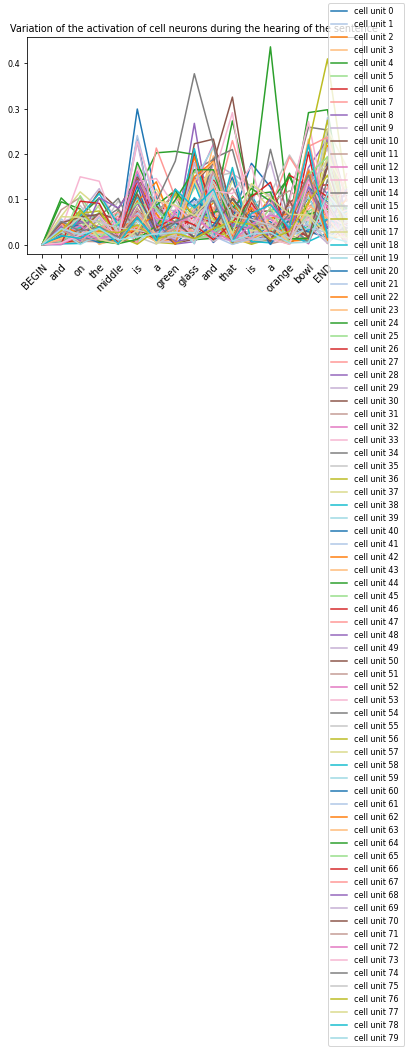

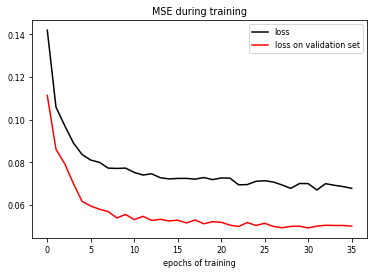

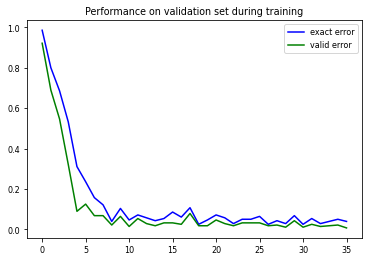

Testing on test set ...
Valid representations :  989 / 1000
Exact representations :  958 / 1000
MSE on test :  0.04913796856999397
RMSE on test :  0.22167085638395043
Testing on training set ...
Valid representations :  997 / 1000
Exact representations :  950 / 1000
MSE on test :  0.04162425920367241
RMSE on test :  0.20402024214198064


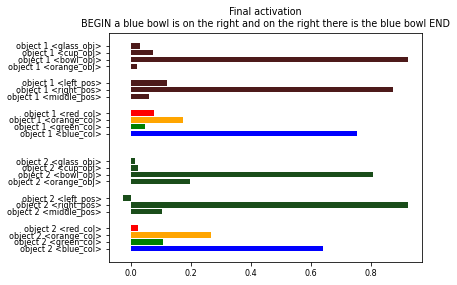

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
masking_3 (Masking)             (None, 19, 20)       0           input_4[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 19, 80), (No 32320       masking_3[0][0]                  
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 80)           0           lstm_3[0][0]                     
____________________________________________________________________________________________

Epoch 8/70
Valid representations :  257 / 280
Exact representations :  239 / 280
MSE on test :  0.057639170438051224
RMSE on test :  0.24008159121026174

Epoch 00008: val_loss improved from 0.05888 to 0.05764, saving model to saved_LSTM/best_model0.5020900089793534.hdf5
500/500 - 3s - loss: 0.0777 - val_loss: 0.0576
Epoch 9/70
Valid representations :  239 / 280
Exact representations :  227 / 280
MSE on test :  0.060300227254629135
RMSE on test :  0.24556104588193367

Epoch 00009: val_loss did not improve from 0.05764
500/500 - 3s - loss: 0.0784 - val_loss: 0.0603
Epoch 10/70
Valid representations :  263 / 280
Exact representations :  254 / 280
MSE on test :  0.05578259378671646
RMSE on test :  0.2361833901584031

Epoch 00010: val_loss improved from 0.05764 to 0.05578, saving model to saved_LSTM/best_model0.5020900089793534.hdf5
500/500 - 3s - loss: 0.0766 - val_loss: 0.0558
Epoch 11/70
Valid representations :  259 / 280
Exact representations :  251 / 280
MSE on test :  0.05454279854893

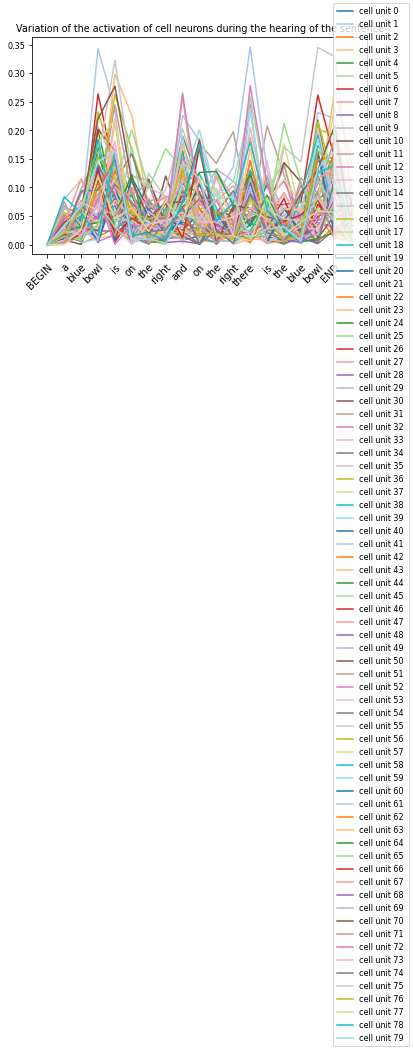

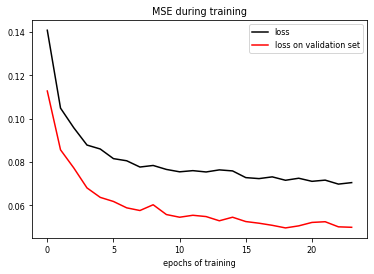

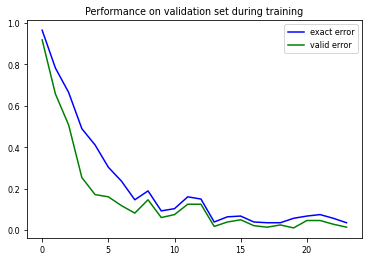

Testing on test set ...
Valid representations :  987 / 1000
Exact representations :  967 / 1000
MSE on test :  0.04885423183441162
RMSE on test :  0.22102993424966588
Testing on training set ...
Valid representations :  996 / 1000
Exact representations :  971 / 1000
MSE on test :  0.04392456263303757
RMSE on test :  0.20958187572649875


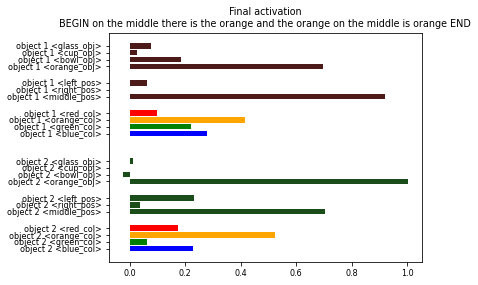

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 19, 20)]     0                                            
__________________________________________________________________________________________________
masking_4 (Masking)             (None, 19, 20)       0           input_5[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 19, 80), (No 32320       masking_4[0][0]                  
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 80)           0           lstm_4[0][0]                     
____________________________________________________________________________________________

Epoch 8/70
Valid representations :  250 / 280
Exact representations :  230 / 280
MSE on test :  0.058223657310009
RMSE on test :  0.24129578800718632

Epoch 00008: val_loss improved from 0.06068 to 0.05822, saving model to saved_LSTM/best_model0.5564458481152785.hdf5
500/500 - 3s - loss: 0.0800 - val_loss: 0.0582
Epoch 9/70
Valid representations :  246 / 280
Exact representations :  225 / 280
MSE on test :  0.05898222327232361
RMSE on test :  0.24286256045822216

Epoch 00009: val_loss did not improve from 0.05822
500/500 - 3s - loss: 0.0762 - val_loss: 0.0590
Epoch 10/70
Valid representations :  256 / 280
Exact representations :  245 / 280
MSE on test :  0.05611293762922287
RMSE on test :  0.23688169542880022

Epoch 00010: val_loss improved from 0.05822 to 0.05611, saving model to saved_LSTM/best_model0.5564458481152785.hdf5
500/500 - 3s - loss: 0.0749 - val_loss: 0.0561
Epoch 11/70
Valid representations :  262 / 280
Exact representations :  252 / 280
MSE on test :  0.05458681657910347

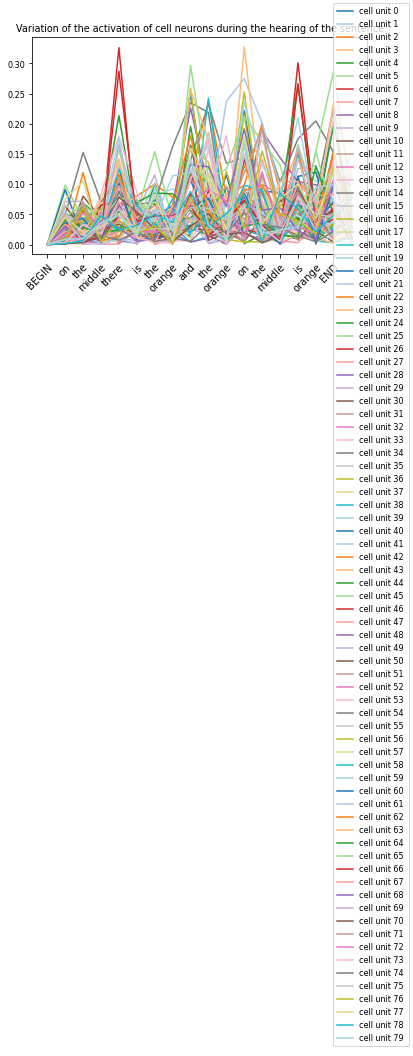

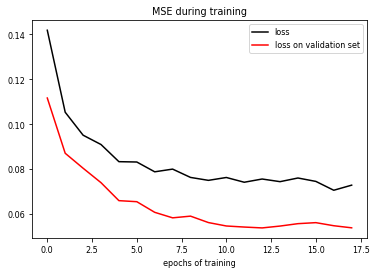

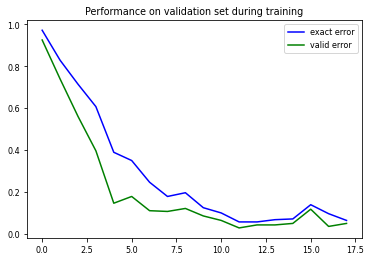

Testing on test set ...
Valid representations :  962 / 1000
Exact representations :  929 / 1000
MSE on test :  0.0527106374502182
RMSE on test :  0.2295879732264262
Testing on training set ...
Valid representations :  982 / 1000
Exact representations :  954 / 1000
MSE on test :  0.04793011397123337
RMSE on test :  0.21892947259616136


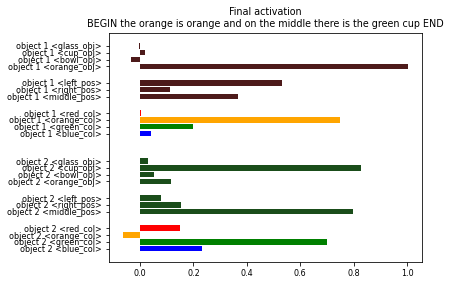

/home/subbainria/Downloads/esn-vs-lstm-on-cross-situationnal-learning/plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


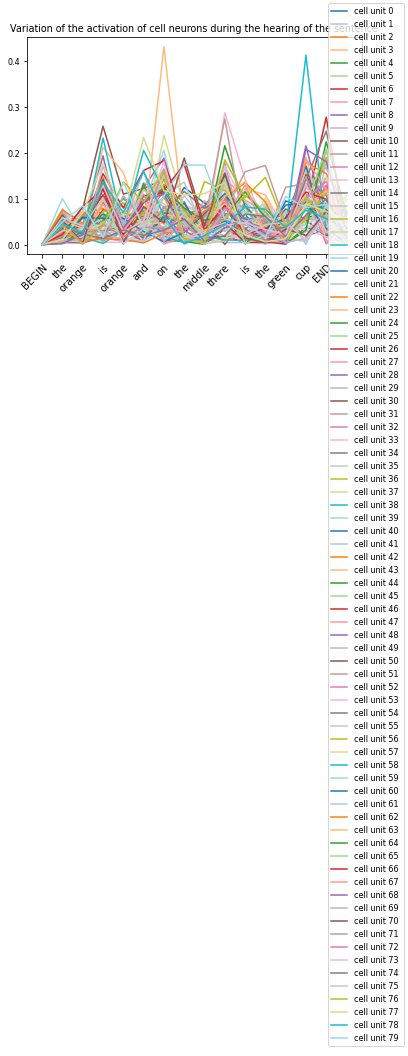

In [21]:
test_version = True
if __name__ == "__main__":
    for i in np.arange(5):
        if use_save_version:
            model = keras.models.load_model(path + "best_model"+rand_id+".hdf5")
            if test_version:
                model_for_test = keras.models.load_model(path + "best_model_for_test"+rand_id+".hdf5")

        else:
            rand_id = str(np.random.random()) #random id used for the file names during the model save

            #build the model
            if test_version:
                inp = Input((max_seq_len, nb_unique_words))
                masked = Masking(mask_value=special_value)(inp)
                lstm_out, state_h, state_c = LSTM(lstm_units, return_state = True, dropout = dropout, return_sequences=True)(masked)
                attention_weights, attention_output = Attention(80)(lstm_out)
                output_to_train = Dense(output_size)(attention_output)

                model = Model(inputs = inp, outputs = output_to_train)
                model_for_test = Model(inputs = inp, outputs = [output_to_train, state_h, state_c])
                model.compile(loss='mean_squared_error', optimizer='adam')
                model_for_test.compile(loss='mean_squared_error', optimizer='adam')

                if verbose_training:
                    print("model for hidden states: ", model_for_test.summary())
            else:
                model = Sequential()
                model.add(Masking(mask_value=special_value, input_shape=(max_seq_len, nb_unique_words)))
                model.add(LSTM(lstm_units, stateful=False, return_sequences=True))
                model.add(Attention(32))
                model.add(Dense(output_size))
                model.compile(loss='mean_squared_error', optimizer='adam')

            if verbose_training:
                print(model.summary()) # print the architecture of the model

            if not(minimal_mode):
                history = LossHistory() #to get the evolution of the loss during training
                checkpoint = ModelCheckpoint("saved_LSTM/best_model"+rand_id+".hdf5",
                                            monitor='val_loss', verbose=1,
                                            mode='auto', period=1, save_best_only = True) #we save the model after each epoch of training
                earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

            t1 = time.process_time()

            #training
            if minimal_mode:
                model.fit(trainX_pad, trainY, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
            else:
                model.fit(trainX_pad, trainY, epochs=nb_epoch, batch_size=batch_size, verbose=2, shuffle=False, callbacks=[history, checkpoint, earlystopping], validation_data=(validationX_pad, validationY))


            t2 = time.process_time()

            if verbose_training:
                print("End of training !")
                print("CPU Time to train : ", t2 -t1)
            if not(minimal_mode):
                model_for_test.save("saved_LSTM/best_model_for_test"+rand_id+".hdf5")
                history.plot_loss()


        if verbose_training:
            print("Testing on test set ...")
        v, ex, er = test_on_test_set(model, testX_pad , testY, test_sentences, verbose_training, threshold_factor)
        if minimal_mode:
            print(str(nb_objects) + "," +str(v) + "," + str(ex) + ","+ str(er) + "," + str(t2-t1))

        if not(minimal_mode):
            if verbose_training:
                print("Testing on training set ...")
            v, ex, er = test_on_test_set(model, trainX_pad , trainY, train_sentences, True, threshold_factor)


        #qualitative analysis of the output of the LSTM
        if not(minimal_mode):
            test_sent = ["BEGIN on the middle is a green glass and that is a orange bowl END", #0
            "BEGIN and on the middle is a green glass and that is a orange bowl END",
            "BEGIN a blue bowl is on the right and on the right there is the blue bowl END",
            "BEGIN on the middle there is the orange and the orange on the middle is orange END", #3
            "BEGIN the orange is orange and on the middle there is the green cup END",
            "BEGIN on the left there is a blue glass and this is a orange END",
            "BEGIN the glass on the left is blue and the bowl on the right is green END", #6
            "BEGIN the orange on the right is green and there is a blue cup on the middle END",
            "BEGIN on the right there is a red glass and the cup on the middle is red END",
            "BEGIN a green glass is on the right and on the left is a orange END"] #9

            #plot the final outputs on a test sentence
            outputs = test_with_sentences(test_sent , model)
            ind = i
            plot_final_activation(outputs[ind],
                                concepts_delimitations,
                                output_id_to_concept_dict,
                                nb_concepts,
                                test_sent[ind])

            #plot and save to png the evolution of the LSTM outputs during the processing of a sentence
            s = test_sent[ind]
            suc_outputs = get_successive_outputs(s, model)
            plot_concept_activation(s,
                                    suc_outputs,
                                    concepts_delimitations,
                                    nb_concepts,
                                    savefig = True,
                                    sub_ttl_fig = s + " LSTM")


            #plot the evolution of cell activity
            activations = get_successive_outputs(s, model_for_test)
            plot_hidden_states(s,
                            model_for_test,
                            units_to_plot = 'all',
                            state = 'cell',
                            plt_var = True,
                            plt_sum = False)

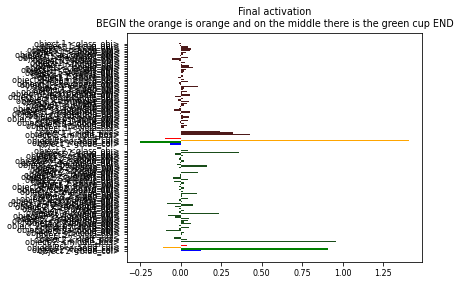

D:\Inria_Projects\esn-vs-lstm-on-cross-situationnal-learning\plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


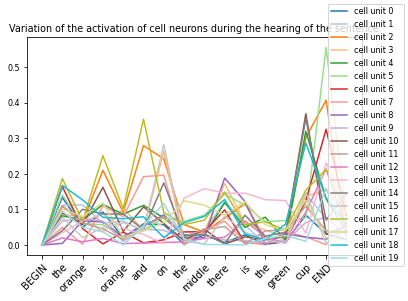

In [28]:
if not(minimal_mode):
            test_sent = ["BEGIN on the middle is a green glass and that is a orange bowl END", #0
            "BEGIN and on the middle is a green glass and that is a orange bowl END",
            "BEGIN a blue bowl is on the right and on the right there is the blue bowl END",
            "BEGIN on the middle there is the orange and the orange on the middle is orange END", #3
            "BEGIN the orange is orange and on the middle there is the green cup END",
            "BEGIN on the left there is a blue glass and this is a orange END",
            "BEGIN the glass on the left is blue and the bowl on the right is green END", #6
            "BEGIN the orange on the right is green and there is a blue cup on the middle END",
            "BEGIN on the right there is a red glass and the cup on the middle is red END",
            "BEGIN a green glass is on the right and on the left is a orange END"] #9

            #plot the final outputs on a test sentence
            outputs = test_with_sentences(test_sent , model)
            ind = i
            plot_final_activation(outputs[ind],
                                concepts_delimitations,
                                output_id_to_concept_dict,
                                nb_concepts,
                                test_sent[ind])

            #plot and save to png the evolution of the LSTM outputs during the processing of a sentence
            s = test_sent[ind]
            suc_outputs = get_successive_outputs(s, model)
            plot_concept_activation(s,
                                    suc_outputs,
                                    concepts_delimitations,
                                    nb_concepts,
                                    savefig = True,
                                    sub_ttl_fig = s + " LSTM")


            #plot the evolution of cell activity
            activations = get_successive_outputs(s, model_for_test)
            plot_hidden_states(s,
                            model_for_test,
                            units_to_plot = 'all',
                            state = 'cell',
                            plt_var = True,
                            plt_sum = False)

In [29]:
model.get_weights()[3].shape

(20, 20)

In [45]:
layers_fn = Model(model.input, model.layers[-5].output)
aa = layers_fn.predict(testX_pad)

In [46]:
aa.shape

(1000, 19)

In [58]:
aa[900]

array([3.2143677e-03, 5.4289293e-03, 1.1902694e-02, 4.4400636e-02,
       5.9350330e-02, 8.6215973e-02, 1.1628633e-01, 5.0927633e-01,
       1.4436994e-01, 9.8009007e-03, 4.1362843e-03, 2.0087415e-03,
       1.3260172e-03, 1.4040711e-03, 1.2666575e-04, 1.8796558e-04,
       1.8796558e-04, 1.8796558e-04, 1.8796558e-04], dtype=float32)

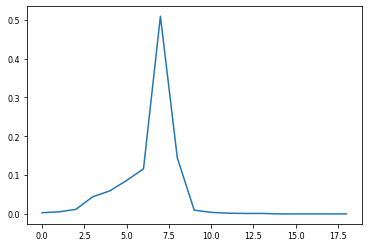

In [55]:
plt.plot(aa[900])

In [56]:
test_sentences[900]

'BEGIN on the right is the violin and a orange lute is on the left END'

In [57]:
word2one_hot_id

{'this': 0,
 'is': 1,
 'a': 2,
 'red': 3,
 'glass': 4,
 'cup': 5,
 'bowl': 6,
 'orange': 7,
 'spoon': 8,
 'apple': 9,
 'accordion': 10,
 'acoustic': 11,
 'bagpipes': 12,
 'banjo': 13,
 'bass': 14,
 'bongo': 15,
 'bugle': 16,
 'cello': 17,
 'clarinet': 18,
 'cymbals': 19,
 'drums': 20,
 'electric': 21,
 'guitar': 22,
 'flute': 23,
 'horn': 24,
 'harmonica': 25,
 'harp': 26,
 'keyboard': 27,
 'maracas': 28,
 'organ': 29,
 'pan': 30,
 'piano': 31,
 'recorder': 32,
 'saxophone': 33,
 'sitar': 34,
 'tambourine': 35,
 'triangle': 36,
 'trombone': 37,
 'trumpet': 38,
 'tuba': 39,
 'ukulele': 40,
 'violin': 41,
 'xylophone': 42,
 'bassoon': 43,
 'castanets': 44,
 'didgeridoo': 45,
 'double': 46,
 'gong': 47,
 'harpsichord': 48,
 'lute': 49,
 'mandolin': 50,
 'oboe': 51,
 'piccolo': 52,
 'viola': 53,
 'green': 54,
 'blue': 55,
 'the': 56,
 'that': 57,
 'on': 58,
 'left': 59,
 'right': 60,
 'middle': 61,
 'center': 62,
 'there': 63,
 'and': 64,
 'BEGIN': 65,
 'END': 66}